# Passenger forecasting using SARIMA

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(xts)
library(zoo)
library(fpp2)
library(forecast)
library(Metrics)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: forecast
Loading required package: fma
Loading required package: expsmooth

Attaching package: ‘Metrics’

The following object is masked from ‘package:forecast’:

    accuracy



## 1. Data import

In [2]:
data <- read_csv('../data/air-passenger/AirPassengers.csv')
head(data)

Parsed with column specification:
cols(
  Month = col_character(),
  `airline passenger monthly totals` = col_double()
)


Month,airline passenger monthly totals
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
1949-06,135


In [3]:
# change the name of column
names(data) <- c('Month', 'passengers')
head(data)
tail(data)

Month,passengers
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
1949-06,135


Month,passengers
1960-07,622
1960-08,606
1960-09,508
1960-10,461
1960-11,390
1960-12,432


## 2. Convert to ts object

In [4]:
# convert to time series object
passenger <-
    ts(
        data[-1],
        frequency = 12,
        start = c(1949, 1),
        end = c(1960, 12)
    )

In [5]:
options(repr.plot.width=8, repr.plot.height=4)

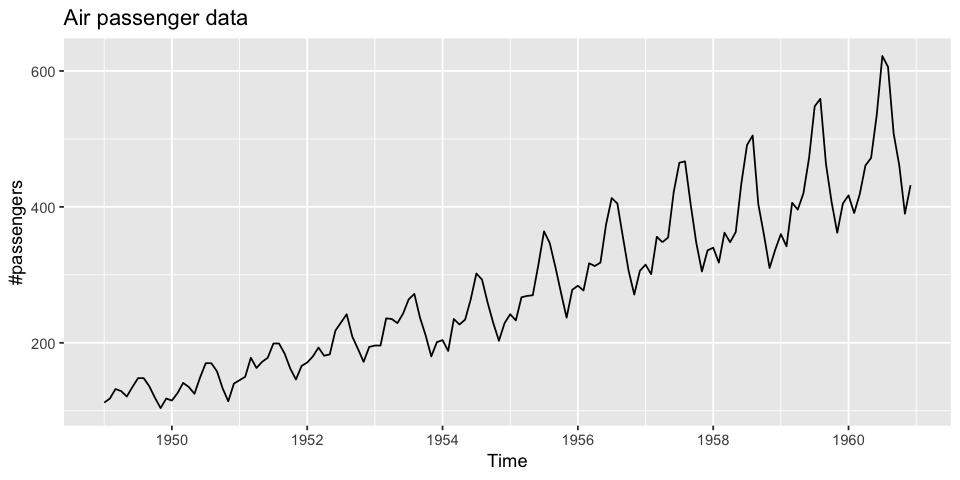

In [6]:
autoplot(passenger) + ylab('#passengers') + ggtitle('Air passenger data')

## 3. Train test split

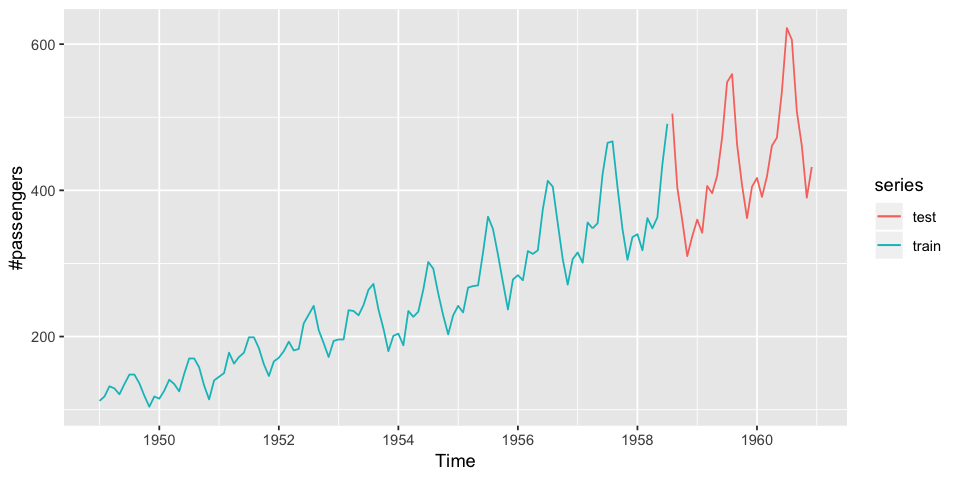

In [7]:
## training and test split
train <- head(passenger, 115)
test <- tail(passenger, 29)

autoplot(train, series = 'train') + autolayer(test, series = 'test') +
    ylab('#passengers')

## 4. Model fitting

In [8]:
## order choosen using brute force method
model <- Arima(y=log(train), order = c(0, 1, 1), 
               seasonal = list(order = c(1, 0, 1), period = 12),
               include.drift = TRUE,
               include.mean = TRUE,
               method = 'ML')

## 5. Model evaluation

In [9]:
one_step_frcst <- Arima(log(test), model = model)

y_train_pred <- fitted(model)
y_test_pred <- fitted(one_step_frcst)

y_train_pred_inv <- exp(y_train_pred)
y_test_pred_inv <- exp(y_test_pred)

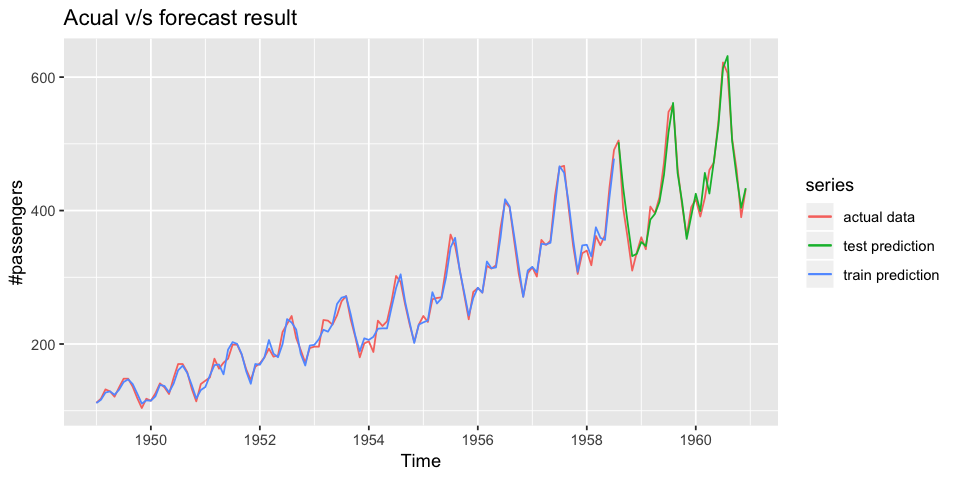

In [10]:
autoplot(passenger, series = 'actual data') +
    autolayer(y_train_pred_inv, series = 'train prediction') +
    autolayer(y_test_pred_inv, series = 'test prediction') +
    xlab('Time') +
    ylab('#passengers') + 
    ggtitle('Acual v/s forecast result')

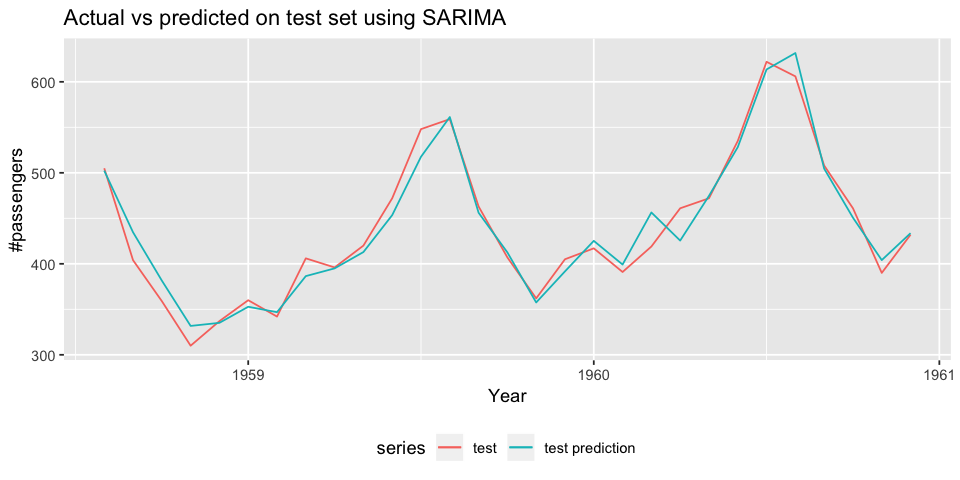

In [11]:
autoplot(test, series = 'test') +
    autolayer(y_test_pred_inv, series = 'test prediction') +
    xlab('Year') +
    ylab('#passengers') +
    ggtitle('Actual vs predicted on test set using SARIMA') +
    theme(legend.position="bottom", legend.box = "horizontal")

In [12]:
train_rmse <- sqrt(mse(train, y_train_pred_inv))
train_mae <- mae(train, y_train_pred_inv)
train_nrmse <- train_rmse/sd(train)

test_rmse <- sqrt(mse(test, y_test_pred_inv))
test_mae <- mae(test, y_test_pred_inv)
test_nrmse <- test_rmse/sd(test)


print(paste0('Training NRMSE :', round(train_nrmse, 3)))
print(paste0('Training MAE :', round(train_mae, 3)))

print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

[1] "Training NRMSE :0.092"
[1] "Training MAE :6.574"
[1] "Test NRMSE :0.207"
[1] "Test MAE :12.51"
